In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import *
import os
import pickle
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec


import warnings
warnings.filterwarnings('ignore')

In [2]:
colors = {'high': '#134f5c', 
          'low': '#cc7351',# '#aa2b1d',# '#cc561e',
          'medium': '#f0a500'}#'#f0a500'

FONT = 'Roboto'


Let's load a bunch of results from the *user_analysis.ipynb* and *content_analysis.ipynb* notebooks.

In [3]:
#load entropy information for URLS
df_urls=pd.read_csv('resources/urls_entropy_info.csv')
df_urls['entropy_class']=df_urls.entropy.apply(eval_item,args=(0.4,0.90))

#load user information from user_analysis.ipynb
user_stats=pd.read_csv('outputs/user_stats.csv')
user_stats['user_id'] = user_stats['user_id'].astype(str)

untrust_dict={k:v for k,v in zip(user_stats.user_id,user_stats.harm_fs)}

#load or process URLs information for the TWITIMM dataset. This file was elaborated in a previous project.
if 'urls_clean.dict' in os.listdir('resources'):
    with open('resources/urls_clean.dict','rb') as fi:
        urls_clean=pickle.load(fi)
else:
    dictfile='resources/urls_rt_only.dict'
    urls_clean=clean_urls(dictfile, df_urls, save=False) #from utils.py

orig={}

for k,v in urls_clean.items():
    orig_list=set([(str(i[2]),i[5]) for i in v if str(i[2])])
    orig[k]=orig_list
    
df_glob = pd.read_csv('outputs/df_glob.csv')
df_glob['user_id'] = df_glob['user_id'].astype(str)
df_glob['overall'] = df_glob['overall'].astype(float)

botscore_dict = {k:v for k,v in zip(df_glob.user_id,df_glob.overall)}

In [4]:
OP_untrust={}

for k,v in orig.items():
    try:
        temp=[untrust_dict[i[0]] for i in v if i[0] in untrust_dict]
        OP_untrust[k]=np.mean(temp)
    except Exception as e:
        continue
        
OP_bot={}

for k,v in orig.items():
    try:
        temp=[botscore_dict[i[0]] for i in v if i[0] in botscore_dict]
        
        OP_bot[k]=np.mean(np.array(temp))
    except Exception as e:
        print(e)
        continue

In [5]:
df_urls['avg_OP_untrust']=df_urls.url.map(OP_untrust)
df_urls['avg_OP_bot']=df_urls.url.map(OP_bot)
df_urls.head()

,url,count,top_community,domain,path,entropy,entropy_class,avg_OP_untrust,avg_OP_bot
0,http://www.ilpopulista.it/news/23-Novembre-201...,1657,Dx/Bufalari,www.ilpopulista.it,/news/23-Novembre-2017/20733/papa-ratzinger-co...,0.628345,medium,0.069935,0.311667
1,https://www.liberoquotidiano.it/news/personagg...,1170,Dx/Bufalari,www.liberoquotidiano.it,/news/personaggi/13370857/roberto-saviano-cont...,1.185045,high,0.049578,0.703333
2,https://www.lastampa.it/2018/09/25/esteri/la-f...,952,Dx/Bufalari,www.lastampa.it,/2018/09/25/esteri/la-francia-dice-no-allattra...,0.941417,high,0.006984,0.233333
3,https://www.liberoquotidiano.it/news/italia/13...,893,Dx/Bufalari,www.liberoquotidiano.it,/news/italia/13372169/don-biancalani-prete-ami...,1.138862,high,0.007822,0.645714
4,http://www.repubblica.it/esteri/2018/08/23/new...,837,Dx/Bufalari,www.repubblica.it,/esteri/2018/08/23/news/ceuta_dopo_24_ore_rima...,0.485498,medium,0.020706,0.280588


In [6]:
#rt_thr=np.percentile(df_urls['count'],75)
rt_thr = 252
col='avg_OP_untrust'

pbc=posterior_by_class(df_urls, col, rt_thr)


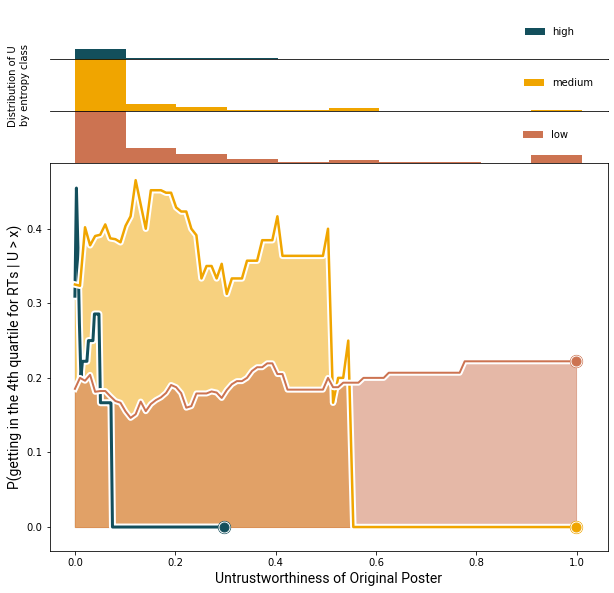

In [7]:
fig = plt.figure(figsize=(10, 10))
subp = GridSpec(4, 1, hspace = 0, height_ratios = [2,2,2,15])


for i, c in enumerate(['low', 'medium', 'high'][::-1]):
    ax = fig.add_subplot(subp[i])
    values = list(df_urls.loc[df_urls['entropy_class'] == c, col].values)
    hist_plot(ax, values, colors[c], label = c)
    
ax = fig.add_subplot(subp[3])
mainplot(ax, pbc, colors, 'Untrustworthiness of Original Poster', 'P(getting in the 4th quartile for RTs | U > x)', FONT)

plt.show()